In [1]:
!pip install rdkit-pypi
!pip install scikit-learn

In [2]:
# import modules
# https://www.rdkit.org/
# https://github.com/rdkit/rdkit
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# https://pandas.pydata.org
import pandas as pd

# https://numpy.org/doc/stable/release.html
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# open csv file
dataset = pd.read_csv('delaney-processed.csv')
dataset.shape

(1128, 10)

In [4]:
# see first five rows of dataframe
dataset.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [5]:
# split training, validation, and test set into 8:1:1 ratio
from sklearn.model_selection import train_test_split
train, temp = train_test_split(dataset, test_size=0.2, random_state=2023)
test, val = train_test_split(temp, test_size=0.5, random_state=2023)

# verify length of each set
print("Training set length: ", len(train))
print("Validation set length: ", len(val))
print("Test set length: ", len(test))

Training set length:  902
Validation set length:  113
Test set length:  113


In [6]:
# check for duplicates and remove them
duplicates_smiles = dataset[dataset['smiles'].duplicated()]['smiles'].values
len(duplicates_smiles)

0

In [7]:
dataset_new = dataset.drop_duplicates(subset=['smiles'])
dataset_new

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [8]:
# calculate molecular descriptors using rdkit
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    # define empty list for molecular descriptors
    Mol_descriptors = []

    # iterate over each molecule
    for mol in mols:
        # add hydrogens to each molecule
        mol = Chem.AddHs(mol)
        # calculate all descriptors
        desc = calc.CalcDescriptors(mol)
        # append descriptors to list
        Mol_descriptors.append(desc)
    return Mol_descriptors, desc_names

# call function
Mol_descriptors, desc_names = RDkit_descriptors(dataset_new['smiles'])

In [9]:
# create dataframe to store molecular descriptors
df_desc = pd.DataFrame(Mol_descriptors, columns=desc_names)
df_desc

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.069684,-5.122500,10.069684,0.911295,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,0,0
1,12.547837,-2.999280,12.547837,0.099444,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,0
2,11.071016,-3.884051,11.071016,1.707414,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,0
3,8.745488,-0.641794,8.745488,0.260568,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,0
4,6.980324,-0.134259,6.980324,0.004630,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,11.196181,-4.713735,11.196181,1.906057,0.523506,197.381,196.373,195.890224,44,0,...,0,0,0,0,0,0,0,0,0,0
1124,12.235172,-3.539125,12.235172,0.407085,0.293876,219.266,206.162,219.067762,80,0,...,1,0,0,0,0,0,0,0,0,0
1125,7.801921,-4.552936,7.801921,0.390035,0.506070,246.359,231.239,245.997179,74,0,...,1,0,0,0,0,0,0,0,0,0
1126,7.421875,-3.723958,7.421875,3.530208,0.444441,72.151,60.055,72.093900,32,0,...,0,0,0,0,0,0,0,0,0,0


# Model 1: Linear Regression w/ 5 Features

In [10]:
# develop linear regression model to predict experimental log solubility
# use five features: 'MolLogP', 'MolMR', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds' - from CSV file
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# define X and y
X = dataset_new[['Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']]
y = dataset_new['ESOL predicted log solubility in mols per litre']

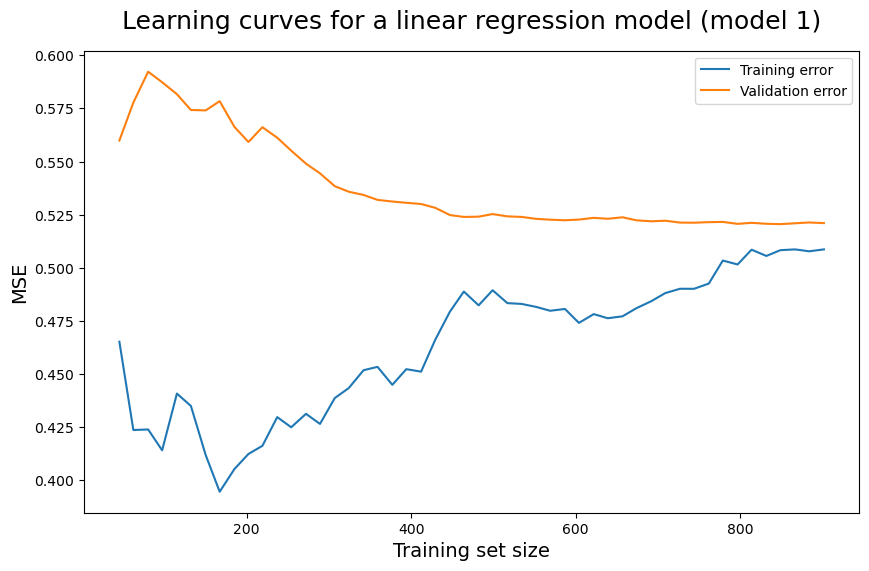

In [11]:
# plot learning curve with training set 
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.05, 1.0, 50))
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training error')
plt.plot(train_sizes, test_errors, label='Validation error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a linear regression model (model 1)', fontsize=18, y=1.03)
plt.legend()
plt.show()

# Since there is a gap between the curves, the training set performs better than the validation set.
# This indicates that the model is overfitting.

In [12]:
# evaluate estimated bias and variance with all training data
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print('Estimated bias: ', np.mean(scores))
print('Estimated variance: ', np.var(scores, ddof=1))

Estimated bias:  -0.5210086057158141
Estimated variance:  0.003428610978020304


# Compare with validation and test sets

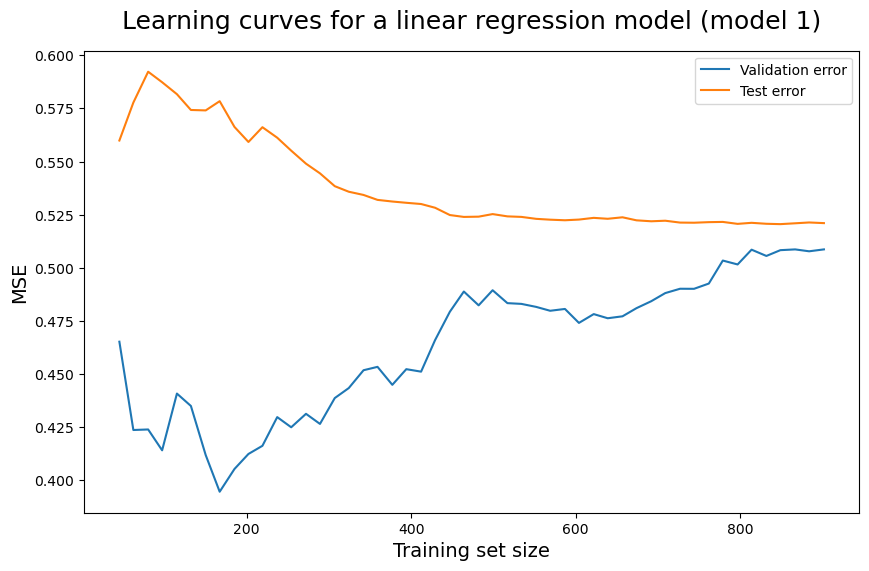

In [13]:
# compare learning curve with validation and test sets
valid_sizes, valid_scores, test_scores = learning_curve(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.05, 1.0, 50))
valid_errors = -valid_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(valid_sizes, valid_errors, label='Validation error')
plt.plot(valid_sizes, test_errors, label='Test error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a linear regression model (model 1)', fontsize=18, y=1.03)
plt.legend()
plt.show()

# Model 2: Random Forest w/ 5 Features

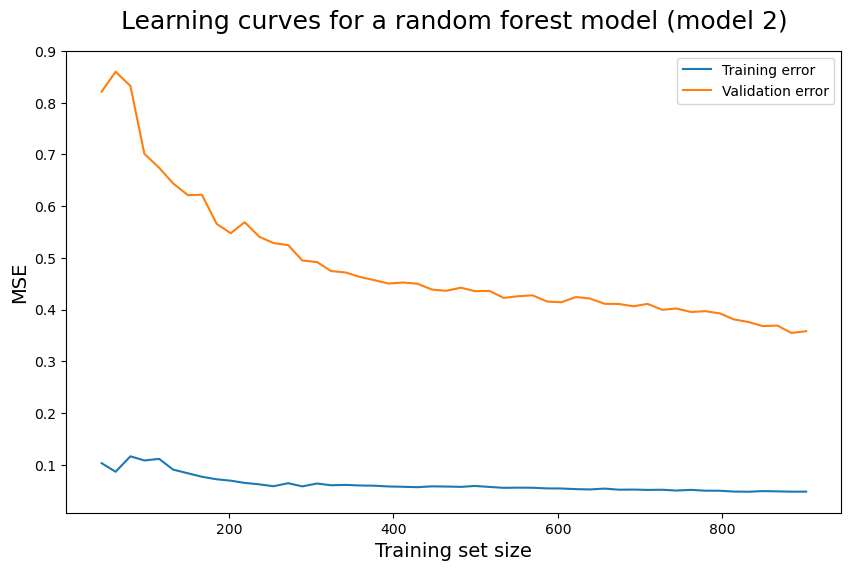

In [14]:
# repeat with a random forest model
from sklearn.ensemble import RandomForestRegressor

train_sizes, train_scores, test_scores = learning_curve(RandomForestRegressor(), X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.05, 1.0, 50))
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training error')
plt.plot(train_sizes, test_errors, label='Validation error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a random forest model (model 2)', fontsize=18, y=1.03)
plt.legend()
plt.show()

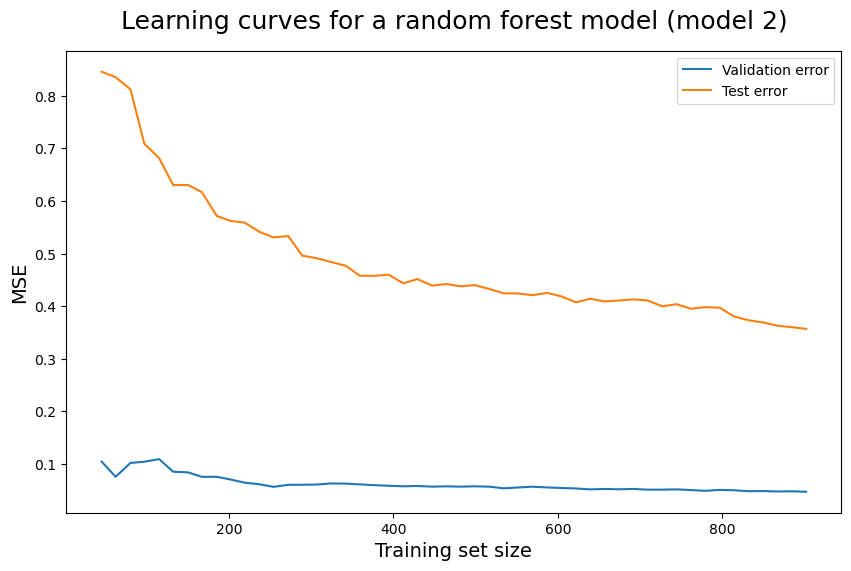

In [15]:
# repeat with validation and test sets - random forest
valid_sizes, valid_scores, test_scores = learning_curve(RandomForestRegressor(), X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.05, 1.0, 50))
valid_errors = -valid_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(valid_sizes, valid_errors, label='Validation error')
plt.plot(valid_sizes, test_errors, label='Test error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a random forest model (model 2)', fontsize=18, y=1.03)
plt.legend()
plt.show()

In [16]:
# evaluate estimated bias and variance for random forest model
scores = cross_val_score(RandomForestRegressor(), X, y, cv=5, scoring='neg_mean_squared_error')
print('Estimated bias: ', np.mean(scores))
print('Estimated variance: ', np.var(scores, ddof=1))

Estimated bias:  -0.3508076232820243
Estimated variance:  0.005347039662131461


# Model 3: Linear Regression w/ All Calculated RdKit Descriptors

In [17]:
# define features and target
X = df_desc
y = dataset_new['ESOL predicted log solubility in mols per litre']

In [18]:
# use standard scaler to standardise data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

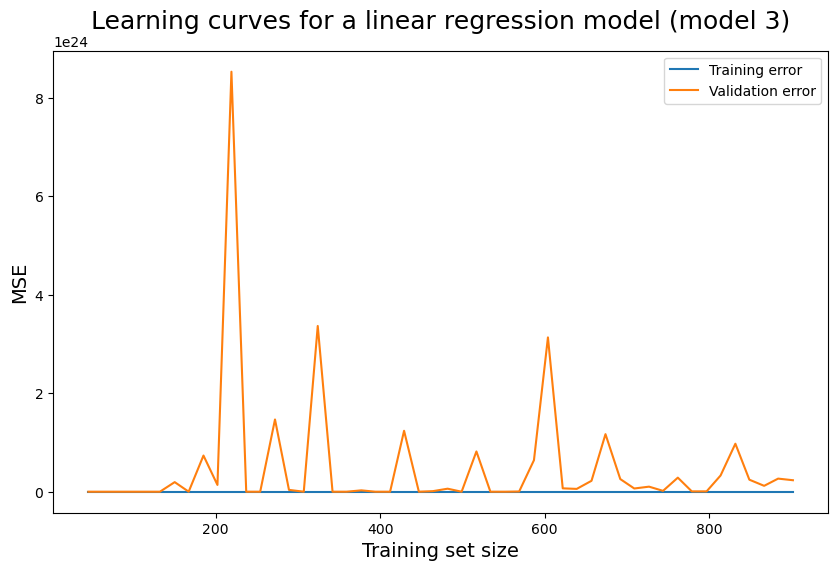

In [19]:
# plot learning curve with training set
train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.05, 1.0, 50))
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training error')
plt.plot(train_sizes, test_errors, label='Validation error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a linear regression model (model 3)', fontsize=18, y=1.03)
plt.legend()
plt.show()

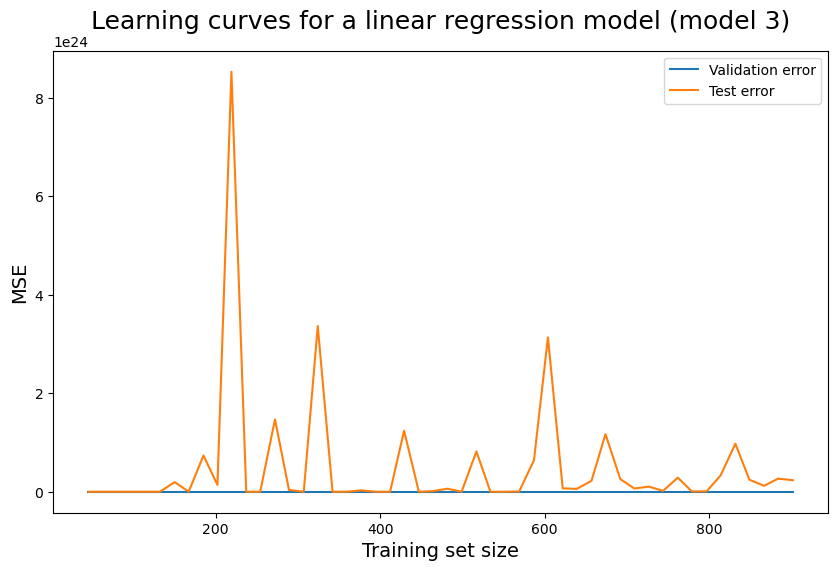

In [20]:
# plot learning curve with validation and test sets
valid_sizes, valid_scores, test_scores = learning_curve(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.05, 1.0, 50))
valid_errors = -valid_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(valid_sizes, valid_errors, label='Validation error')
plt.plot(valid_sizes, test_errors, label='Test error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a linear regression model (model 3)', fontsize=18, y=1.03)
plt.legend()
plt.show()

In [21]:
# evaluate estimated bias and variance for linear regression model with all rdkit descriptors
scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print('Estimated bias: ', np.mean(scores))
print('Estimated variance: ', np.var(scores, ddof=1))

Estimated bias:  -2.334720583112442e+23
Estimated variance:  2.6819682865531572e+47


In [22]:
# develop lasso regression model using 10-fold cross validation
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=10, random_state=42).fit(X, y)
print('Best alpha: ', lasso.alpha_)

Best alpha:  0.0027011402873746457


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-02, tolerance: 1.276e-02
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.754e-02, tolerance: 1.818e-02
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.782e-02, tolerance: 2.392e

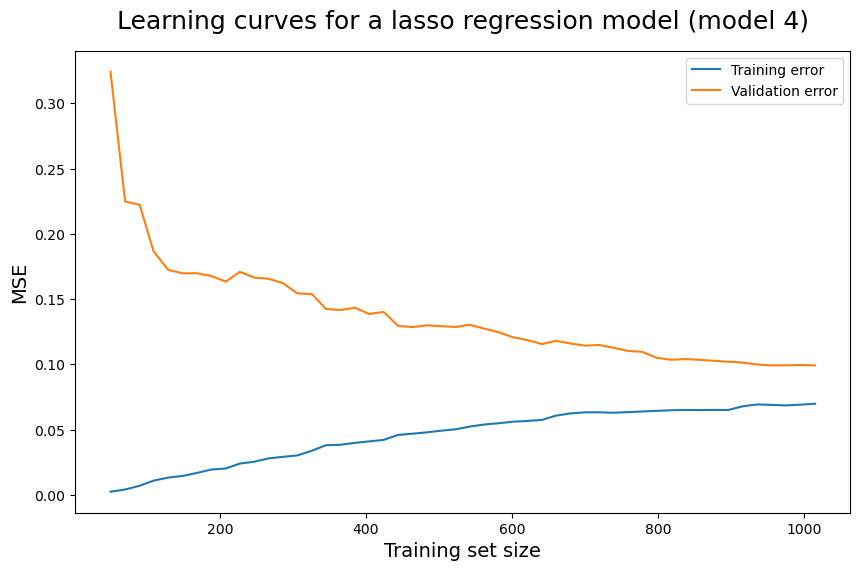

In [23]:
# use alpha value to plot learning curve
from sklearn.linear_model import Lasso

train_sizes, train_scores, test_scores = learning_curve(Lasso(alpha=0.0027011402873746457), X, y, cv=10, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.05, 1.0, 50))
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training error')
plt.plot(train_sizes, test_errors, label='Validation error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a lasso regression model (model 4)', fontsize=18, y=1.03)
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.143e-02, tolerance: 1.054e-02
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.569e-02, tolerance: 3.373e-02
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.286e-01, tolerance: 9.673e

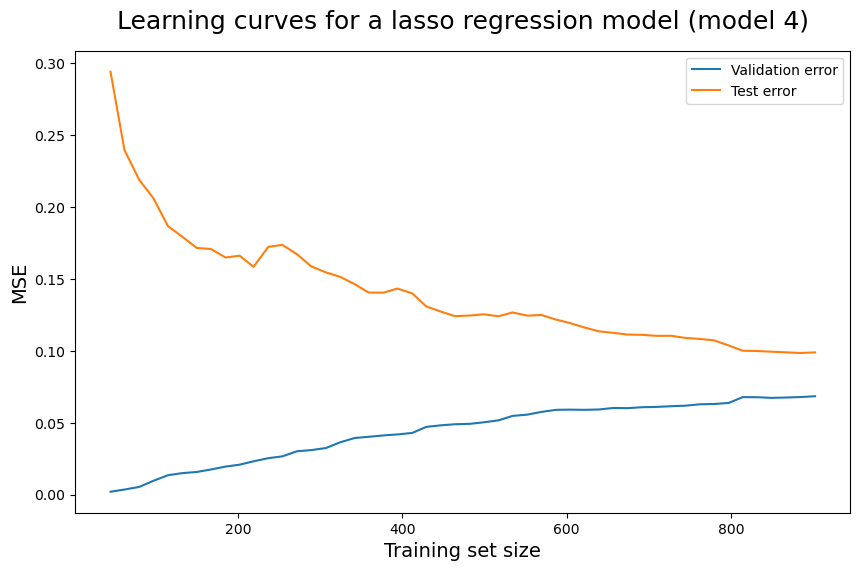

In [25]:
# repeat with validation and test sets - lasso
valid_sizes, valid_scores, test_scores = learning_curve(Lasso(alpha=0.0027011402873746457), X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.05, 1.0, 50))
valid_errors = -valid_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(valid_sizes, valid_errors, label='Validation error')
plt.plot(valid_sizes, test_errors, label='Test error')
plt.ylabel('MSE', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves for a lasso regression model (model 4)', fontsize=18, y=1.03)
plt.legend()
plt.show()

In [26]:
# evaluate estimated bias and variance for lasso regression model
scores = cross_val_score(Lasso(alpha=0.0027011402873746457), X, y, cv=5, scoring='neg_mean_squared_error')
print('Estimated bias: ', np.mean(scores))
print('Estimated variance: ', np.var(scores, ddof=1))

Estimated bias:  -0.09851601744487994
Estimated variance:  0.00016633833006141579
